In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_curve, confusion_matrix, accuracy_score, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler 
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
%matplotlib inline


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [3]:
# data 
data = pd.read_csv('C:\\Users\\gianl\\Capstone2\\data\Real_fake_news_EDAed.csv')
links = ['facbooolink','bitlyylinkk','youtubelink','twitterlink', 'tmsnrtlinnk'] # this will be used during modeling
y = data['Real_Fake'] # dependent variable 

#extraction of linguistic indexes and scaling

Linguistic_index = data[['Gulpease_title', 'Flesh_Kin_Grade_title', 'ARI_title', 'smog_title', 'sent_text', 'Complex_words_text', 'CLI_text', 'sent_title', 'Gulpease_text', 'Flesh_Kin_Grade_text', 'Long_words_title', 'Count_words_title', 'Complex_words_title']]
scale= StandardScaler()
Ling_Indexes_scaled = scale.fit_transform(Linguistic_index)

# MODELING

### 1- Logistic Regression: Linguistic indexes ONLY, 

In [4]:
#split data
X_train_ling, X_test_ling, y_train_ling, y_test_ling = train_test_split(Ling_Indexes_scaled, y, test_size =0.2)

In [5]:
ling_regres = LogisticRegression()
params = {'C': [0.01, 0.1, 1, 10, 100]}

Model_1 = GridSearchCV(ling_regres, params, cv = 4)
Model_1.fit(X_train_ling, y_train_ling)

y_pred_1 = Model_1.predict(X_test_ling)

print('Balanced Accuracy is', balanced_accuracy_score(y_test_ling, y_pred_1, adjusted = True))
print('Best param is', Model_1.best_params_)

Balanced Accuracy is 0.7510820256179729
Best param is {'C': 0.1}


In [6]:
probs = Model_1.predict_proba(X_test_ling)[:,1]
fpr, tpr, threshold = roc_curve(y_test_ling, probs)
roc_auc_LR_IN = auc(fpr, tpr)

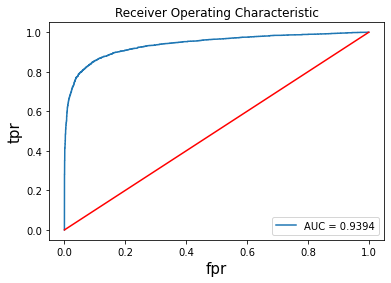

In [7]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc_LR_IN)
plt.plot([0,1], [0,1], color = 'red')
plt.legend(loc = 'lower right')
plt.xlabel('fpr', fontsize = 15)
plt.ylabel('tpr', fontsize = 15)
plt.show()

In [8]:
# Summary Logistic regression on Indexes 
Log_Reg_index = ['{:.4f}'.format(balanced_accuracy_score(y_test_ling, y_pred_1, adjusted = True)), round(roc_auc_LR_IN, 4)]
Log_Reg_index

['0.7511', 0.9394]

### 2 - MultinomialNB: CountVectorizer on Lemmetized text

In [9]:
# Results from multinomial Naive Bayes, CountVectorizer, max_df = 0.65

min_df1 = [15, 25, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000, 10000]
Balanced_acc1 = []
words1 = []

for i in min_df1:
    vectorizer = CountVectorizer(min_df = i, max_df=0.65, stop_words = None)
    vectorizer.fit(data['text_nlp_lem'])
    x_v_min_df = vectorizer.transform(data['text_nlp_lem'])
    x_v_min_df = x_v_min_df.toarray()
    words1.append(x_v_min_df.shape[1])
    x_train, x_test, y_train, y_test = train_test_split(x_v_min_df , y, test_size = 0.2, random_state = 42)

    classif = MultinomialNB()
    classif.fit(x_train, y_train)
    y_pred = classif.predict(x_test)

    Balanced_acc1.append(float('{:.4f}'.format(balanced_accuracy_score(y_test, y_pred, adjusted =True))))
    
for i,j in zip(min_df1, Balanced_acc1):
    print('min_df =', i, 'Balanced accuracy =', j )

min_df = 15 Balanced accuracy = 0.8926
min_df = 25 Balanced accuracy = 0.8899
min_df = 50 Balanced accuracy = 0.8905
min_df = 100 Balanced accuracy = 0.8891
min_df = 200 Balanced accuracy = 0.8821
min_df = 300 Balanced accuracy = 0.8821
min_df = 400 Balanced accuracy = 0.8816
min_df = 500 Balanced accuracy = 0.8863
min_df = 1000 Balanced accuracy = 0.8796
min_df = 2000 Balanced accuracy = 0.8854
min_df = 5000 Balanced accuracy = 0.8841
min_df = 10000 Balanced accuracy = 0.843


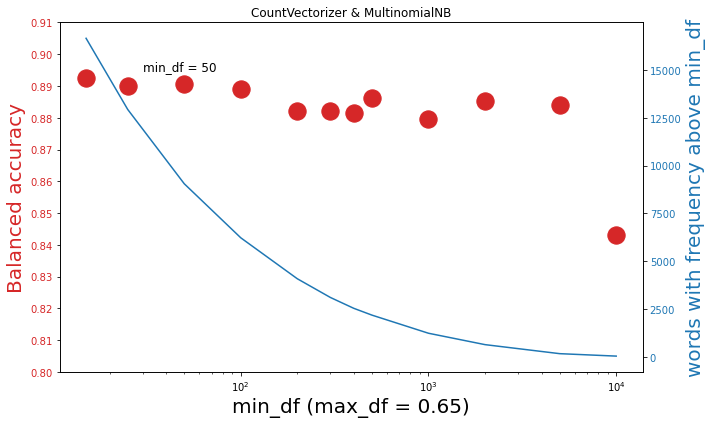

In [10]:
#plotting results

fig, ax1 = plt.subplots(figsize =(10,6))
plt.title('CountVectorizer & MultinomialNB')
color = 'tab:red'
ax1.scatter(min_df1, Balanced_acc1, color = color, s=300)
ax1.set_ylabel('Balanced accuracy', color = color, fontsize = 20)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('min_df (max_df = 0.65)', fontsize = 20)
ax1.yaxis.set_ticks(np.arange(0.80, 0.92, 0.01))
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(min_df1, words1, color = color)
ax2.set_ylabel('words with frequency above min_df', color = color , fontsize = 20)
ax2.tick_params(axis='y', labelcolor=color)
plt.annotate('min_df = 50', xytext=(30, 15000), xy=(800, 1500), fontsize = 12)
plt.tight_layout()
plt.savefig('C:\\Users\\gianl\\Capstone2\\figures\\accuracy_CountVectorizer_MultinomialNB.tiff', dpi =120)
plt.show();

In [11]:
# Picked min_df = 15 and 50.
# Let's check different alpha values, with and without token for links


param_grid = {'alpha':[0.01, 0.1]}

best_param =[]
min_df = []
acc = []
token_links = [False, True]
link_exclud =[]
stop = 0

for i in [15, 50]:
    for link in token_links:
        if link == False:
            stop = links
        else: 
            stop = None
        counter_v_no_link = CountVectorizer(min_df = i, max_df= 0.65, stop_words = stop)
        counter_v_no_link.fit(data['text_nlp_lem'])
        array = counter_v_no_link.transform(data['text_nlp_lem'])
        array = array.toarray()
    
        x_train, x_test, y_train, y_test = train_test_split(array, y, test_size = 0.2, random_state = 42)
    
        classiNB = MultinomialNB()
        grid_s_nolink = GridSearchCV(classiNB, param_grid = param_grid, cv = 3 )
        grid_s_nolink.fit(x_train, y_train)
    
        ypred = grid_s_nolink.predict(x_test)
    
        acc.append(float('{:.3f}'.format(balanced_accuracy_score(y_test, ypred, adjusted = True))))
        best_param.append(grid_s_nolink.best_params_)
        min_df.append(i)
        link_exclud.append(link)
        

results = pd.DataFrame({'min_df': min_df, 'best_param': best_param, 'Balanced accuracy':acc, 'token links included': link_exclud})
results

,min_df,best_param,Balanced accuracy,token links included
0,15,{'alpha': 0.01},0.893,False
1,15,{'alpha': 0.01},0.897,True
2,50,{'alpha': 0.01},0.887,False
3,50,{'alpha': 0.01},0.894,True


In [12]:
# conclusion: lack of the tokens reduces the balanced accuracy of only 0.4-0.7 %, let's keep the them for now.
# With min_df = 50 is slightly less accurate than min_df= 15, but it is way faster.  

In [13]:
# Ngrams with CountVectorizer (min_df = 50, max_df=0.65), with links, check 2 values of alpha (0.01, 0.1), multinomial NB

ngram =[]
best_param = []
accuracy = []
param_grid = {'alpha':[0.01, 0.1]}

first_g = [1,1,1,2,2,3]
second_g = [1,2,3,2,3,3]

for i,j in zip(first_g, second_g):
    counter_ng = CountVectorizer(min_df = 50, max_df=0.65, ngram_range =(i,j))
    counter_ng.fit(data['text_nlp_lem'])
    x_v_min_df_g = counter_ng.transform(data['text_nlp_lem'])
    x_v_min_df_g = x_v_min_df_g.toarray()
    x_train_g, x_test_g, y_train_g, y_test_g = train_test_split(x_v_min_df_g , y, test_size = 0.20, random_state = 42)
     
    classifNB2 = MultinomialNB()
    gm_sv = GridSearchCV(classifNB2, param_grid = param_grid, cv= 3)
    gm_sv.fit(x_train_g, y_train_g)

    y_pred_cv = gm_sv.predict(x_test_g)
    ngram.append(str(i)+','+str(j))
    best_param.append(gm_sv.best_params_)
    accuracy.append(balanced_accuracy_score(y_test_g, y_pred_cv, adjusted = True))
    
results_CV = pd.DataFrame({'ngram':ngram, 'best_param': best_param,'Balanced accuracy': accuracy })
print('Results from CountVectorizer, min_df = 50, max_df=0.65')
results_CV

Results from CountVectorizer, min_df = 50, max_df=0.65


,ngram,best_param,Balanced accuracy
0,"1,1",{'alpha': 0.01},0.893505
1,"1,2",{'alpha': 0.01},0.934893
2,"1,3",{'alpha': 0.01},0.944396
3,"2,2",{'alpha': 0.01},0.943528
4,"2,3",{'alpha': 0.01},0.946663
5,"3,3",{'alpha': 0.01},0.765977


In [14]:
# Let's draw the ROC curve for CountVectorizer ngram2.3, min_df = 50, max_df =0.65, alpha =0.01
Vect_final = CountVectorizer(min_df = 50, max_df =0.65, ngram_range =(2,3))
x_words_Vect_final = Vect_final.fit_transform(data['text_nlp_lem'])
x_words_Vect_final = x_words_Vect_final.toarray()
    
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_words_Vect_final, y, random_state = 42, test_size =0.2)

classifNB_CV_23 = MultinomialNB(alpha = 0.01)
classifNB_CV_23.fit(x_train1, y_train1)

y_pred_cv = classifNB_CV_23.predict(x_test1)

print('Balanced accuaracy is', balanced_accuracy_score(y_test1, y_pred_cv ,adjusted = True))

Balanced accuaracy is 0.9466628905817283


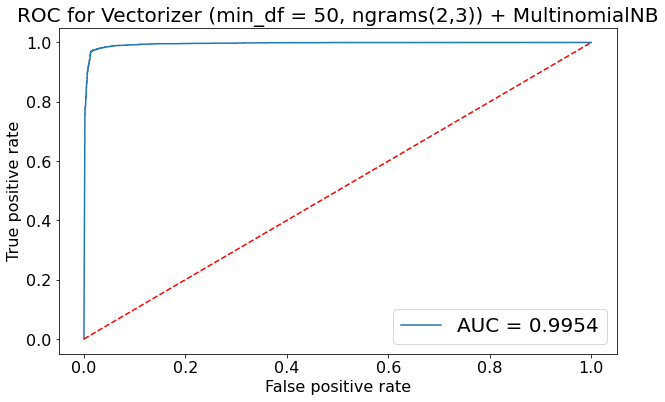

In [15]:
probs = classifNB_CV_23.predict_proba(x_test1)
pred = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test1, pred)
roc_auc_CV23 = auc(fpr, tpr)

plt.figure(figsize =(10,6))
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc_CV23)
plt.legend(loc = 'lower right',fontsize = 20)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC for Vectorizer (min_df = 50, ngrams(2,3)) + MultinomialNB',fontsize = 20)
plt.xlabel('False positive rate',fontsize = 16)
plt.ylabel('True positive rate',fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

In [16]:
# Summary Multinomial NB on Lem text with countVectorizer
CountVectorizer_ngram23 = [round(balanced_accuracy_score(y_test1, y_pred_cv ,adjusted = True), 4), round(roc_auc_CV23, 4)]
CountVectorizer_ngram23

[0.9467, 0.9954]

### 3 - MultinomialNB: TFIDFVectorizer on Lemmetized text

In [17]:
min_dfidf = [15, 25, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000, 10000]
Balanced_ac_tfidfc = []
words_tfidf = []

for i in min_dfidf:
    TermFIDF = TfidfVectorizer(min_df = i, max_df=0.65)
    TermFIDF.fit(data['text_nlp_lem'])
    x_v_min_df = TermFIDF.transform(data['text_nlp_lem'])
    x_v_min_df = x_v_min_df.toarray()
    words_tfidf.append(x_v_min_df.shape[1])
    x_train, x_test, y_train, y_test = train_test_split(x_v_min_df , y, test_size = 0.2, random_state = 42)

    classif = MultinomialNB()
    classif.fit(x_train, y_train)
    y_pred = classif.predict(x_test)

    Balanced_ac_tfidfc.append(float('{:.4f}'.format(balanced_accuracy_score(y_test, y_pred, adjusted =True))))

for i,j in zip(min_dfidf, Balanced_ac_tfidfc):
    print('min_df =', i, 'Balanced accuracy =', j )

min_df = 15 Balanced accuracy = 0.8673
min_df = 25 Balanced accuracy = 0.8642
min_df = 50 Balanced accuracy = 0.8631
min_df = 100 Balanced accuracy = 0.8631
min_df = 200 Balanced accuracy = 0.8611
min_df = 300 Balanced accuracy = 0.8566
min_df = 400 Balanced accuracy = 0.8591
min_df = 500 Balanced accuracy = 0.8598
min_df = 1000 Balanced accuracy = 0.8584
min_df = 2000 Balanced accuracy = 0.8531
min_df = 5000 Balanced accuracy = 0.8567
min_df = 10000 Balanced accuracy = 0.8186


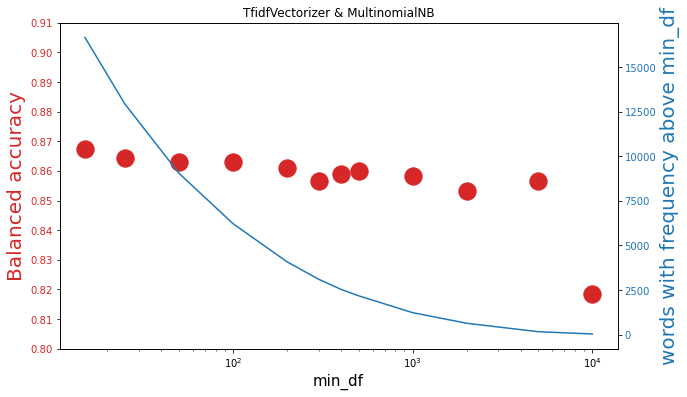

In [18]:
#plotting results

fig, ax1 = plt.subplots(figsize =(10,6))
plt.title('TfidfVectorizer & MultinomialNB')
color = 'tab:red'
ax1.scatter(min_dfidf, Balanced_ac_tfidfc, color = color, s=300)
ax1.set_ylabel('Balanced accuracy', color = color, fontsize = 20)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('min_df', fontsize =15)
ax1.yaxis.set_ticks(np.arange(0.80, 0.92, 0.01))
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(min_dfidf, words_tfidf, color = color)
ax2.set_ylabel('words with frequency above min_df' ,  color = color, fontsize = 20)
ax2.tick_params(axis='y', labelcolor=color)
plt.savefig('C:\\Users\\gianl\\Capstone2\\figures\\accuracy_TFIDF_MultinomialNB.tiff')
plt.show();

In [19]:
# Picked min_df = 15 and 50. Max accuracy is when min_df is 15, but the number of words is huge == computational expensive. 
# I would prefer to keep min_df = 50 and let's check different alpha values, with or without token links

param_grid = {'alpha':[0.01, 0.1]}

best_paramTF =[]
min_df = []
accTF = []
token_links = [False, True]
link_exclud =[]
stop = 0 

for i in [15, 50]:
    for link in token_links:
        if link == False:
            stop = links
        else: 
            stop = None
        counter_v_no_link = TfidfVectorizer(min_df = i, max_df= 0.65, stop_words = stop)
        counter_v_no_link.fit(data['text_nlp_lem'])
        array = counter_v_no_link.transform(data['text_nlp_lem'])
        array = array.toarray()
    
        x_train, x_test, y_train, y_test = train_test_split(array, y, test_size = 0.2, random_state = 42)
    
        classiNB = MultinomialNB()
        grid_s_nolink = GridSearchCV(classiNB, param_grid = param_grid, cv = 3 )
        grid_s_nolink.fit(x_train, y_train)
    
        ypred = grid_s_nolink.predict(x_test)
    
        accTF.append(float('{:.3f}'.format(balanced_accuracy_score(y_test, ypred, adjusted = True))))
        best_paramTF.append(grid_s_nolink.best_params_)
        min_df.append(i)
        link_exclud.append(link)

results_TFIDF = pd.DataFrame({'min_df': min_df, 'best_param': best_paramTF, 'Balanced accuracy':accTF, 'token links included': link_exclud})
results_TFIDF

,min_df,best_param,Balanced accuracy,token links included
0,15,{'alpha': 0.01},0.868,False
1,15,{'alpha': 0.01},0.872,True
2,50,{'alpha': 0.01},0.863,False
3,50,{'alpha': 0.01},0.866,True


In [20]:
# conclusion: lack of the tokens reduces the balanced accuracy of only 0.3-0.4 %, let's keep them for now.
# With min_df = 50 is slightly less accurate than min_df= 15, but it is way faster.

In [21]:
# Let's check different Ngrams with TfidfVectorizer (min_df = 50, max_df=0.65), with links, check 2 values of alpha (0.01, 0.1), multinomial NB
ngram =[]
best_param = []
accuracy_TFIDF = []
param_grid = {'alpha':[0.01, 0.1]}

first_g = [1,1,1,2,2,3]
second_g = [1,2,3,2,3,3]

for i,j in zip(first_g, second_g):
    TermFIDF = TfidfVectorizer(min_df = 50, ngram_range =(i,j))
    x_words_IF_IDF = TermFIDF.fit_transform(data['text_nlp_lem'])
    
    x_train, x_test, y_train, y_test = train_test_split(x_words_IF_IDF, y, random_state = 42, test_size =0.2)

    
    classifNB2 = MultinomialNB()
    gm_sv = GridSearchCV(classifNB2, param_grid = param_grid, cv= 3)
    gm_sv.fit(x_train, y_train)

    y_pred_cv = gm_sv.predict(x_test)
    ngram.append(str(i)+','+str(j))
    best_param.append(gm_sv.best_params_)
    accuracy_TFIDF.append(balanced_accuracy_score(y_test, y_pred_cv ,adjusted = True))
    
results_TFIDF = pd.DataFrame({'ngram':ngram, 'best_param': best_param,'Balanced accuracy': accuracy_TFIDF })
results_TFIDF

,ngram,best_param,Balanced accuracy
0,"1,1",{'alpha': 0.01},0.868080
1,"1,2",{'alpha': 0.01},0.917975
2,"1,3",{'alpha': 0.01},0.931519
3,"2,2",{'alpha': 0.01},0.929415
4,"2,3",{'alpha': 0.01},0.938490
5,"3,3",{'alpha': 0.01},0.770545


In [22]:
# Let's draw the ROC curve for TfidfVectorizer ngram2.3, min_df = 50, max_df =0.65, alpha =0.01
Vect_final_Tfidf = TfidfVectorizer(min_df = 50, max_df =0.65, ngram_range =(2,3))
x_words_Tfidf_final = Vect_final_Tfidf.fit_transform(data['text_nlp_lem'])
x_words_Tfidf_final = x_words_Tfidf_final.toarray()
    
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_words_Tfidf_final, y, random_state = 42, test_size =0.2)

    
classifNB_TFIDF_23 = MultinomialNB(alpha =0.01)
classifNB_TFIDF_23.fit(x_train2, y_train2)

y_pred_tfidf = classifNB_TFIDF_23.predict(x_test2)

print('Balanced accuaracy is', balanced_accuracy_score(y_test2, y_pred_tfidf ,adjusted = True))

Balanced accuaracy is 0.938489744440127


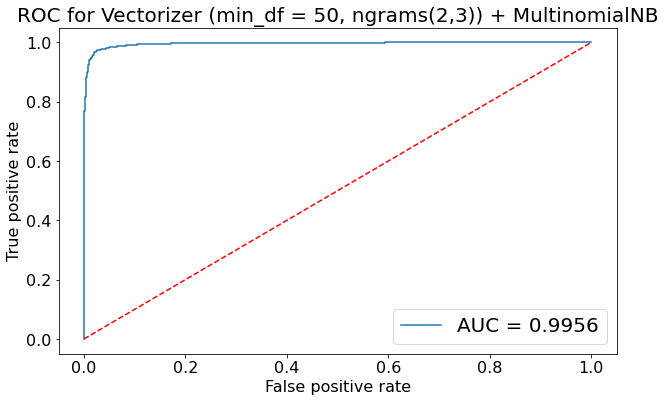

In [23]:
probs = classifNB_TFIDF_23.predict_proba(x_test2)
pred = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test1, pred)
roc_auc_TFIDF23 = auc(fpr, tpr)

plt.figure(figsize =(10,6))
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc_TFIDF23)
plt.legend(loc = 'lower right',fontsize = 20)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC for Vectorizer (min_df = 50, ngrams(2,3)) + MultinomialNB',fontsize = 20)
plt.xlabel('False positive rate',fontsize = 16)
plt.ylabel('True positive rate',fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

In [24]:
# Summary Multinomial NB on Lem text with TfidfVectorizer
TfidfVectorizer_ngram23 = [round(balanced_accuracy_score(y_test2, y_pred_tfidf ,adjusted = True),4), round(roc_auc_CV23, 4)]
TfidfVectorizer_ngram23

[0.9385, 0.9954]

### Comparison models 2 and 3 ngrams

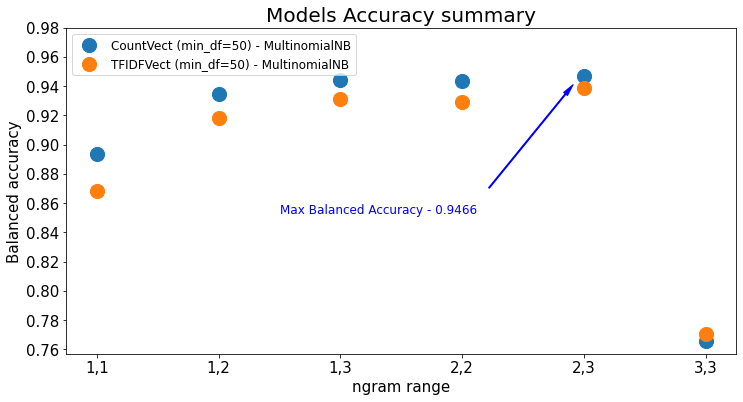

In [25]:
plt.figure(figsize=(12,6))
plt.scatter(results_CV['ngram'], results_CV['Balanced accuracy'], label = 'CountVect (min_df=50) - MultinomialNB', s= 200)
plt.scatter(results_CV['ngram'], results_TFIDF['Balanced accuracy'], label = 'TFIDFVect (min_df=50) - MultinomialNB', s= 200)
plt.ylabel('Balanced accuracy', fontsize =15)
plt.xlabel('ngram range', fontsize =15)
plt.title('Models Accuracy summary', fontsize =20)
plt.yticks(np.arange(0.76, 0.99, 0.02), fontsize = 15)
plt.xticks( fontsize = 15)
plt.legend(loc='upper left', fontsize = 12)
#plt.arrow('2,3', 0.94, -0.3, -0.1, width = 0.01)
plt.annotate('Max Balanced Accuracy - 0.9466', fontsize = 12, xy= (4.0, 0.95), xytext=(1.5, 0.860), 
             arrowprops = dict(color='blue', width=1, headwidth=5, shrink=0.1), va = 'top', color = 'blue')
plt.savefig('C:\\Users\\gianl\\Capstone2\\figures\\balance_accuracy_Vect_and_TFIDF_ngrams_MultinomialNB.tiff', dpi =120)
plt.show()

**BEST MODELS, between 2 and 3, are:**
- CountVectorizer ngram2.3, min_df = 50, max_df =0.65, alpha =0.01
- TfidfVectorizer ngram2.3, min_df = 50, max_df =0.65, alpha =0.01

### 4 - Logistic Regression: CountVectorizer on Lemmetized text & Linguistic indexes  

In [26]:
# CountVectorizer(min_df = 50, ngram_range =(2,3), max_df =0.65) + Scaled linguist indexes

vectorizer = CountVectorizer(min_df = 50, ngram_range = (2,3), max_df=0.65)
vectorizer.fit(data['text_nlp_lem'])
x_v_mins = vectorizer.transform(data['text_nlp_lem'])
x_v_mins = x_v_mins.toarray()

# merge data 
X_total_scaled = pd.concat([pd.DataFrame(Ling_Indexes_scaled), pd.DataFrame(x_v_mins)], axis = 1)

# split train/test sets
x_train_ts, x_test_ts, y_train_ts, y_test_ts = train_test_split(X_total_scaled, y, random_state = 42, test_size =0.2)


In [27]:
fina_Reg = LogisticRegression(max_iter=2000)
param = {'C':[1,10,20]}

Final_Grid_Log = GridSearchCV(fina_Reg, param, cv = 3)
Final_Grid_Log.fit(x_train_ts, y_train_ts)

print('Balanced accuracy is ', '{:.4}'.format(balanced_accuracy_score(y_test_ts, Final_Grid_Log.predict(x_test_ts), adjusted= True)))
print('best C is', Final_Grid_Log.best_params_)

Balanced accuracy is  0.9836
best C is {'C': 10}


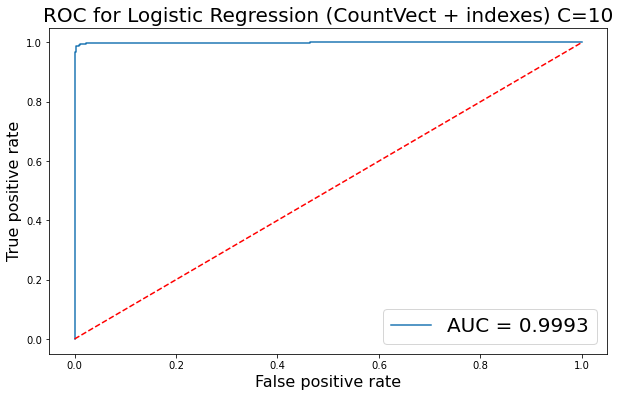

In [28]:
# Draw the ROC curve
probs2 = Final_Grid_Log.predict_proba(x_test_ts)
pred2 = probs2[:,1]
fpr, tpr, threshold = roc_curve(y_test_ts, pred2)
roc_auc_cv = auc(fpr, tpr)

plt.figure(figsize =(10,6))
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc_cv)
plt.legend(loc = 'lower right',fontsize = 20)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC for Logistic Regression (CountVect + indexes) C=10',fontsize = 20)
plt.xlabel('False positive rate',fontsize = 16)
plt.ylabel('True positive rate',fontsize = 16)
plt.show()

In [29]:
# Summary Logistic Regression on Lem text with countVectorizer 2,3 + indexes
Logistic_CV_23_plus_index = [round(balanced_accuracy_score(y_test_ts, Final_Grid_Log.predict(x_test_ts), adjusted= True),4), round(roc_auc_cv, 4)]
Logistic_CV_23_plus_index

[0.9836, 0.9993]

### 5 - Logistic Regression: TfidfVectorizer on Lemmetized text & Linguistic indexes

In [30]:
# TfidfVectorizer(min_df = 50, ngram_range =(2,3), max_df =0.65) + Scaled linguist indexes

TermFIDF_50 = TfidfVectorizer(min_df = 50, ngram_range =(2,3), max_df =0.65)
x_words_IF_IDF = TermFIDF_50.fit_transform(data['text_nlp_lem'])
x_words_IF_IDF = x_words_IF_IDF.toarray()

# merge data 
X_total_scaled_ifidf = pd.concat([pd.DataFrame(Ling_Indexes_scaled), pd.DataFrame(x_words_IF_IDF)], axis = 1)

# split train/test sets
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_total_scaled_ifidf, y, random_state = 42, test_size =0.2)

In [31]:
fina_Reg2 = LogisticRegression(max_iter=2000)
param = {'C':[200, 260]}


Final_Grid_Logidf = GridSearchCV(fina_Reg2, param, cv = 3)
Final_Grid_Logidf.fit(x_train_tfidf, y_train_tfidf)

print('Balanced accuracy is ', '{:.4}'.format(balanced_accuracy_score(y_test_tfidf, Final_Grid_Logidf.predict(x_test_tfidf), adjusted = True)))
print('best C is', Final_Grid_Logidf.best_params_ )

Balanced accuracy is  0.9831
best C is {'C': 200}


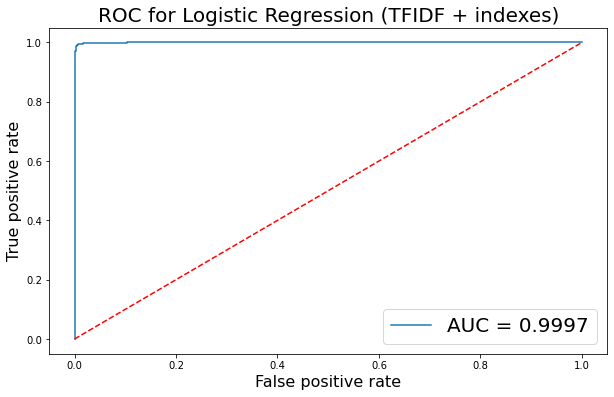

In [32]:
# Draw the ROC curve

probs3 = Final_Grid_Logidf.predict_proba(x_test_tfidf)
pred3 = probs3[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfidf, pred3)
roc_auc_tfidf = auc(fpr, tpr)

plt.figure(figsize =(10,6))
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc_tfidf)
plt.legend(loc = 'lower right',fontsize = 20)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC for Logistic Regression (TFIDF + indexes)',fontsize = 20)
plt.xlabel('False positive rate',fontsize = 16)
plt.ylabel('True positive rate',fontsize = 16)
plt.show()

In [33]:
# Summary Logistic Regression on Lem text with TfidfVectorizer 2,3 + indexes
Logistic_TFIDF_23_plus_index = ['{:.4}'.format(balanced_accuracy_score(y_test_tfidf, Final_Grid_Logidf.predict(x_test_tfidf), adjusted = True)), round(roc_auc_tfidf, 4)]
Logistic_TFIDF_23_plus_index

['0.9831', 0.9997]

***MODELS 4-5 PERFORMANCE SUMMARY***

In [34]:
print('MODEL 4: Balanced Accuracy', Logistic_CV_23_plus_index[0], ', AUC', Logistic_CV_23_plus_index[1])
print('MODEL 5: Balanced Accuracy', Logistic_TFIDF_23_plus_index[0], ', AUC', Logistic_TFIDF_23_plus_index[1])

MODEL 4: Balanced Accuracy 0.9836 , AUC 0.9993
MODEL 5: Balanced Accuracy 0.9831 , AUC 0.9997


### 6 - Random Forest: CountVectorizer on Lemmetized text & Linguistic indexes 

In [35]:
classifRF_CV = RandomForestClassifier()
params = {'n_estimators': [50,100],
    'max_depth' : [None, 2 ],
    'min_samples_leaf':  [1, 3]}


RandoF_CV = GridSearchCV(classifRF_CV, params, cv = 3)
RandoF_CV.fit(x_train_ts, y_train_ts)

y_pred_RF = RandoF_CV.predict(x_test_ts)
acc_CV_RF = balanced_accuracy_score(y_test_ts, y_pred_RF, adjusted = True)

print('Best params are', RandoF_CV.best_params_)
print('accuracy is', round(acc_CV_RF, 4))

Best params are {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
accuracy is 0.9729


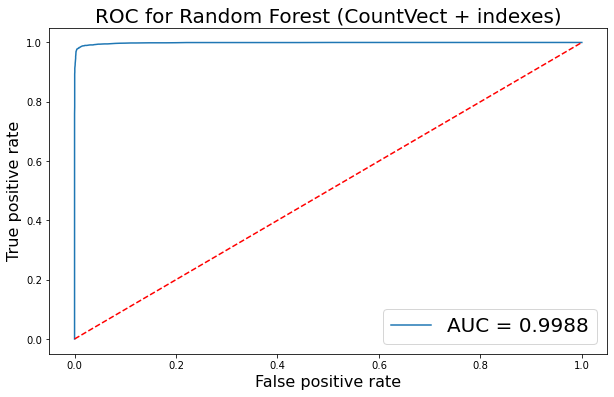

In [36]:
# Draws the ROC curve 
probs4 = RandoF_CV.predict_proba(x_test_ts)
pred4 = probs4[:,1]
fpr, tpr, threshold = roc_curve(y_test_ts, pred4)
roc_auc_RF1 = auc(fpr, tpr)

plt.figure(figsize =(10,6))
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc_RF1)
plt.legend(loc = 'lower right',fontsize = 20)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC for Random Forest (CountVect + indexes)',fontsize = 20)
plt.xlabel('False positive rate',fontsize = 16)
plt.ylabel('True positive rate',fontsize = 16)
plt.show()

In [37]:
# Summary RandomForestClassifier on Lem text with CountVectorizer 2,3 + indexes
RandomF_CV_23_plus_index = [round(acc_CV_RF, 4), round(roc_auc_RF1, 4)]
RandomF_CV_23_plus_index

[0.9729, 0.9988]

### 7 - Random Forest: TfidfVectorizer on Lemmetized text & Linguistic indexes 

In [38]:
classifRF_TFIDF = RandomForestClassifier()
params = {'n_estimators': [50,100],
    'max_depth' : [None, 2 ],
    'min_samples_leaf':  [1, 3]}


RandoF_TFIDF = GridSearchCV(classifRF_TFIDF, params, cv = 3)
RandoF_TFIDF.fit(x_train_tfidf, y_train_tfidf)

y_pred_RF2 = RandoF_TFIDF.predict(x_test_tfidf)
acc_TFIDF_RF = balanced_accuracy_score(y_test_tfidf, y_pred_RF2, adjusted = True)

print('Best params are', RandoF_TFIDF.best_params_)

Best params are {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}


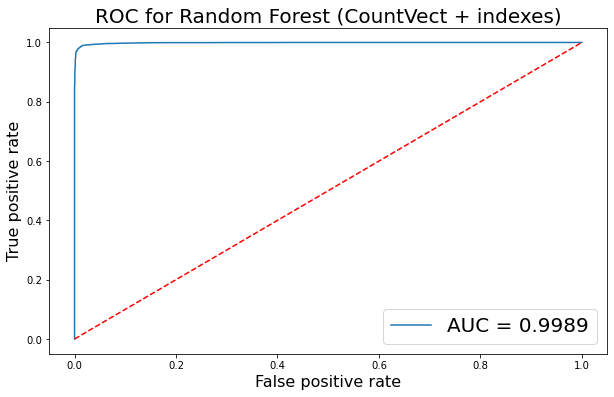

In [39]:
# Draws the ROC curve 
probs5 = RandoF_TFIDF.predict_proba(x_test_tfidf)
pred5 = probs5[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfidf, pred5)
roc_auc_RF2 = auc(fpr, tpr)

plt.figure(figsize =(10,6))
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc_RF2)
plt.legend(loc = 'lower right',fontsize = 20)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC for Random Forest (CountVect + indexes)',fontsize = 20)
plt.xlabel('False positive rate',fontsize = 16)
plt.ylabel('True positive rate',fontsize = 16)
plt.show()

In [40]:
# Summary RandomForestClassifier on Lem text with TfidfVectorizer 2,3 + indexes
RandomF_TFIDF_23_plus_index = [round(acc_TFIDF_RF, 4), round(roc_auc_RF2, 4)]
RandomF_TFIDF_23_plus_index

[0.9707, 0.9989]

***MODELS 6-7 PERFORMANCE SUMMARY***

In [41]:
print('MODEL 6: Balanced Accuracy', RandomF_CV_23_plus_index[0], ', AUC', RandomF_CV_23_plus_index[1])
print('MODEL 7: Balanced Accuracy', RandomF_TFIDF_23_plus_index[0], ', AUC', RandomF_TFIDF_23_plus_index[1])

MODEL 6: Balanced Accuracy 0.9729 , AUC 0.9988
MODEL 7: Balanced Accuracy 0.9707 , AUC 0.9989


## All results together

In [42]:
# MODEL comparison
models = pd.DataFrame(np.array([Log_Reg_index, CountVectorizer_ngram23, TfidfVectorizer_ngram23, Logistic_CV_23_plus_index,Logistic_TFIDF_23_plus_index, RandomF_CV_23_plus_index, RandomF_TFIDF_23_plus_index]), columns=['Balanced Accuracy', 'AUC'], 
                      index = ['Log Reg on indexes', 'CountVect ngram23 on Lem Text', 'TfidftVect ngram23 on Lem Text', 'Log Reg CountVect ngram23 plus index', 'Log Reg TFIDFVect ngram23 plus index', 'RandomF CountVect ngram23 plus index', 'RandomF TFIDFVect ngram23 plus index'])
models

,Balanced Accuracy,AUC
Log Reg on indexes,0.7511,0.9394
CountVect ngram23 on Lem Text,0.9467,0.9954
TfidftVect ngram23 on Lem Text,0.9385,0.9954
Log Reg CountVect ngram23 plus index,0.9836,0.9993
Log Reg TFIDFVect ngram23 plus index,0.9831,0.9997
RandomF CountVect ngram23 plus index,0.9729,0.9988
RandomF TFIDFVect ngram23 plus index,0.9707,0.9989


## Log Reg TFIDFVect ngram23 plus index is the best model

In [43]:
# MODELING WITH and withouth LINK TOKENS and the word reuters to see how they affect the performance of the model

all_gone = ['facbooolink','bitlyylinkk','youtubelink','twitterlink', 'tmsnrtlinnk', 'reuters']
no_reuters = ['reuters']
no_token_links = ['facbooolink','bitlyylinkk','youtubelink','twitterlink', 'tmsnrtlinnk']

stopw = [no_token_links,  no_reuters, all_gone, None]

balance_accuracy=[]
auc_Model = []
Links_token = []


for i in stopw:
    vectorizer = CountVectorizer(min_df = 50, ngram_range = (2,3), max_df=0.65, stop_words = i)
    vectorizer.fit(data['text_nlp_lem'])
    x_v_mins = vectorizer.transform(data['text_nlp_lem'])
    x_v_mins = x_v_mins.toarray()

    # merge data 
    X_total_scaled = pd.concat([pd.DataFrame(Ling_Indexes_scaled), pd.DataFrame(x_v_mins)], axis = 1)

    # split train/test sets
    x_train_ts, x_test_ts, y_train_ts, y_test_ts = train_test_split(X_total_scaled, y, random_state = 42, test_size =0.2)
    
    
    fina_Reg = LogisticRegression(max_iter=2000)
    param = {'C':[10]}

    Final_Grid_Log = GridSearchCV(fina_Reg, param, cv = 3)
    Final_Grid_Log.fit(x_train_ts, y_train_ts)
    
    y_pred = Final_Grid_Log.predict(x_test_ts)
    balance_accuracy.append(round(balanced_accuracy_score(y_test_ts, y_pred, adjusted = True), 4))
    Links_token.append(i)
    probs = Final_Grid_Log.predict_proba(x_test_ts)[:,1]
    
    fpr, tpr , threshold = roc_curve(y_test_ts, probs)
    auc_Model.append(auc(fpr, tpr))
    
Tables_Perf = pd.DataFrame({'Excluded' : ['Link tokens', 'Reuters word', 'Both', 'None'], 'balance_accuracy': balance_accuracy, 'AUC' : auc_Model})
Tables_Perf.sort_values('balance_accuracy', ascending = False)

,Excluded,balance_accuracy,AUC
3,None,0.9836,0.999308
0,Link tokens,0.9820,0.999303
1,Reuters word,0.9733,0.998467
2,Both,0.9728,0.998444


# Conclusion:
Removal of the word 'Reuters' alone drops the balanced accuracy of 1%. While removal of both of the word 'Reuters' and the link token leads to a 1.1% drop of the balanced accuracy. 

The model is still pretty accurate.

# Few more analysis with model 4 

### Let's check the missclassified news by model 4, the highest performant one 

In [44]:
# print confusion matrix for model 4 on the test set
pred = Final_Grid_Log.predict(x_test_ts)
print(confusion_matrix(y_test_ts, pred ))
print(classification_report(y_test_ts, pred ))

[[4191   20]
 [  41 3464]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4211
           1       0.99      0.99      0.99      3505

    accuracy                           0.99      7716
   macro avg       0.99      0.99      0.99      7716
weighted avg       0.99      0.99      0.99      7716



In [45]:
classified = pd.DataFrame(y_test_ts)
classified['prediction'] = pred
missclassified = classified[classified['Real_Fake'] != classified['prediction']]
missclassified

,Real_Fake,prediction
1232,1,0
6492,0,1
3704,1,0
1465,1,0
3288,1,0
...,...,...
22618,1,0
33133,0,1
37413,0,1
22832,1,0


In [46]:
# the text below belongs to a Fake New, but it was classified as Real
# reading it, it appears legit.
data.iloc[1232, 2]

' the people have spoken and it is clear that americans are 100% fed up! with the sanctuary city policy and illegal immigration. embattled san francisco sheriff ross mirkarimi convincingly lost his bid for re-election tuesday after spending months in the national spotlight as the face of his city s controversial sanctuary city policy on illegal immigration. the murder of kate steinle brought to the forefront the sanctuary city policy in san francisco. the refusal to acknowledge the illegality of this policy and the treatment of the steinle family  could not be more shameful. our hope is that this landslide sends a message to those who have been ignoring the rule of law. our thoughts and prayers go out to the steinle family who have suffered so much. mirkarimi, 54, was defeated by vicki hennessy, a former sheriff s official who had the endorsement of san francisco mayor ed lee and the sheriff deputies association. with 42 percent of precincts reporting, henessy had received 63 percent o

In [47]:
# the text below belongs to a real New, but it was classified as Fake. 
data.iloc[6492, 2]

" (reuters) - drugmaker valeant pharmaceuticals international inc's (vrx. to) new chief executive, joseph papa, will receive a base salary of $1. 5 million, the company said in a filing on wednesday. valeant said on monday former perrigo co plc (prgo. n) head papa would replace michael pearson as its ceo. papa will also receive a cash payment of $8 million to make up for the equity-based compensation he forfeited in connection with the termination of his employment with perrigo. valeant said in march pearson was leaving the company, just three weeks after returning from a two-month medical leave. pearson's base salary for full-year 2014 was $2 million and his total compensation amounted to $10. 3 million, according to a regulatory filing. (1. usa. gov/1aapxim)"

In [48]:
#The low Flesh_Kin_Grade_text of this new may have contributed to the missclassification 
data.iloc[6492,:]

Unnamed: 0                                                            6492
date                                                            2016-04-27
text                      (reuters) - drugmaker valeant pharmaceuticals...
title                     valeant to pay new ceo papa base salary of $1...
Real_Fake                                                                0
Cat_Government News                                                      0
Cat_Middle-east                                                          0
Cat_News                                                                 0
Cat_US_News                                                              0
Cat_left-news                                                            0
Cat_politics                                                             0
Cat_politicsNews                                                         1
Cat_worldnews                                                            0
sent_title               

In [49]:
# these are the kincaid indexed of the news classified as fake when actually were real
miss = data.iloc[missclassified[missclassified['Real_Fake']==0].index, 25]
miss

6492      8.793636
12535    10.850581
4448     12.608059
33164    13.165135
29071     8.584153
14186    10.643223
4699      9.610363
35821    14.534821
32422    10.326250
26250     9.296690
37432     8.049537
5174     11.764530
5662     12.585107
28163    13.759176
13705    14.083973
2726      8.406864
32314     9.116638
28204    13.920919
33133    11.142222
37413    11.852121
Name: Flesh_Kin_Grade_text, dtype: float64

In [50]:
# plot the Flesh_Kin_Grade_text for the real news classified as fake 

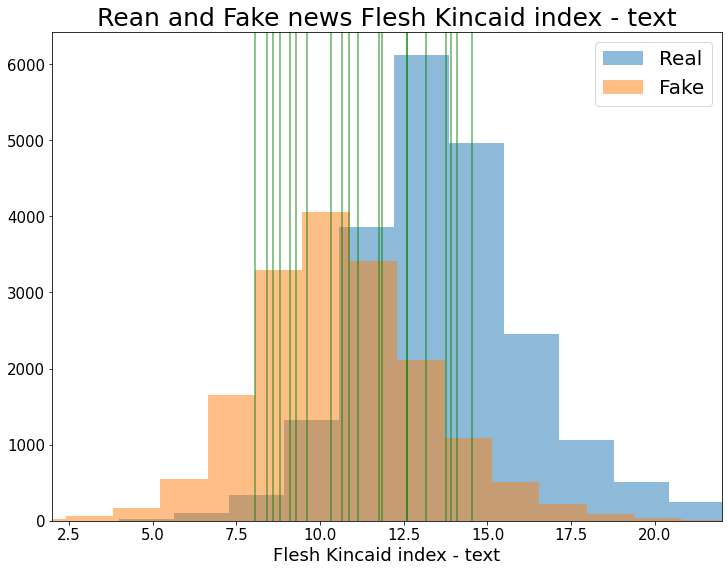

In [51]:
plt.figure(figsize = (12,9))
plt.hist(data[data['Real_Fake']==0]['Flesh_Kin_Grade_text'], bins =50, alpha = 0.5, label = 'Real')
plt.hist(data[data['Real_Fake']==1]['Flesh_Kin_Grade_text'],  bins =50, alpha = 0.5, label = 'Fake')
plt.legend(fontsize = 20)
for i in miss.values:
    plt.axvline(x= i ,alpha = 0.6, color = 'green')
plt.xlabel('Flesh Kincaid index - text', fontsize = 18 )
plt.title('Rean and Fake news Flesh Kincaid index - text', fontsize =25 )
plt.xlim(2,22)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('C:\\Users\\gianl\\Capstone2\\figures\\miss_classified_real news.tiff', dpi =120)
plt.show();

In [52]:
# Conclusion: hard to make a definitive statement. 
# It seems that the real news classified as Fake are concentrated in the left half
# of the histogram of the Flesh_Kin_Grade_text for real news